In [1]:
from prophet import Prophet
import pandas as pd
import numpy as np
from numpy import log
import matplotlib.pyplot as plt
from matplotlib import pyplot 
import seaborn as sns
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import sklearn.metrics as metrics
from sklearn.metrics import mean_absolute_error, r2_score, median_absolute_error, mean_squared_error

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
df = pd.read_csv('merge_data.csv')

In [3]:
df.shape

(2127863, 35)

In [4]:
#df.isnull().sum()

In [5]:
#Feature Engering 
df1 = df[['date', 'quantity', 'country', 'sales']]

In [6]:
df1.isnull().sum()

date         0
quantity     0
country     46
sales        0
dtype: int64

In [7]:
df2 = df1.dropna()

In [8]:
df2.isnull().sum()

date        0
quantity    0
country     0
sales       0
dtype: int64

In [9]:
df3=df2.groupby('date')['quantity', 'sales'].sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [10]:
df3

,quantity,sales
date,,
2019-06-01,154,4062.217799
2019-06-02,6,70.147357
2019-06-03,37,1354.000653
2019-06-04,2583,70505.743012
2019-06-05,2584,66170.902135
...,...,...
2022-01-10,3938,109472.937561
2022-01-11,3773,112798.634218
2022-01-12,3721,102618.516796


In [11]:
df_3 = df3['quantity']

In [12]:
df3.reset_index(inplace=True)

In [13]:
df4 = df3[['date', 'quantity']]

In [14]:
df_3_m = df3['quantity']

In [15]:
df4.dtypes

date        object
quantity     int64
dtype: object

<function matplotlib.pyplot.show(*args, **kw)>

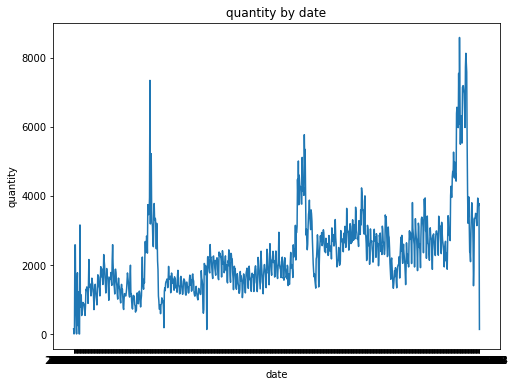

In [16]:
plt.figure(figsize =(8,6))

plt.plot(df_3)
plt.xlabel('date')
plt.ylabel('quantity')
plt.title('quantity by date')
plt.show

# Moving Average 

In [17]:
#Method1
df_m = df2.groupby('date')['quantity'].sum().to_frame()
df_m

,quantity
date,
2019-06-01,154
2019-06-02,6
2019-06-03,37
2019-06-04,2583
2019-06-05,2584
...,...
2022-01-10,3938
2022-01-11,3773
2022-01-12,3721


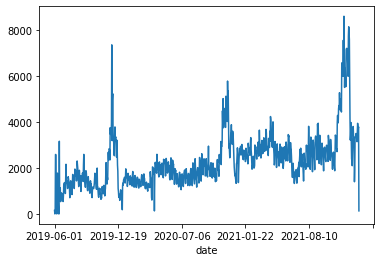

In [18]:
df_m['quantity'].plot()

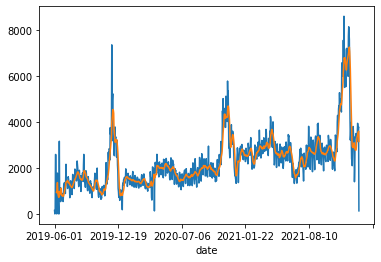

In [19]:
df_m['quantity'].plot()
df_m['quantity'].rolling(window=7).mean().plot()

In [20]:
df_m['m_averaging']=df_m['quantity'].rolling(window=7).mean()
df_m.head(10)

,quantity,m_averaging
date,,
2019-06-01,154,NaN
2019-06-02,6,NaN
2019-06-03,37,NaN
2019-06-04,2583,NaN
2019-06-05,2584,NaN
2019-06-06,798,NaN
2019-06-07,463,946.428571
2019-06-08,5,925.142857
2019-06-10,1357,1118.142857


In [21]:
mae = mean_absolute_error(df_m['quantity'][6:],df_m['m_averaging'][6:])
print('MAE:%.3f' % mae)

MAE:326.335


In [22]:
#method 2
#time series Decomposition
train_len = 800
train = df_m[0:train_len]
test = df_m[train_len:]

In [23]:
# ma_window 7
y_hat_sma = df_m.copy()
ma_window = 7
y_hat_sma['sma_forecast'] = df_m['quantity'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:]=y_hat_sma['sma_forecast'][train_len-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


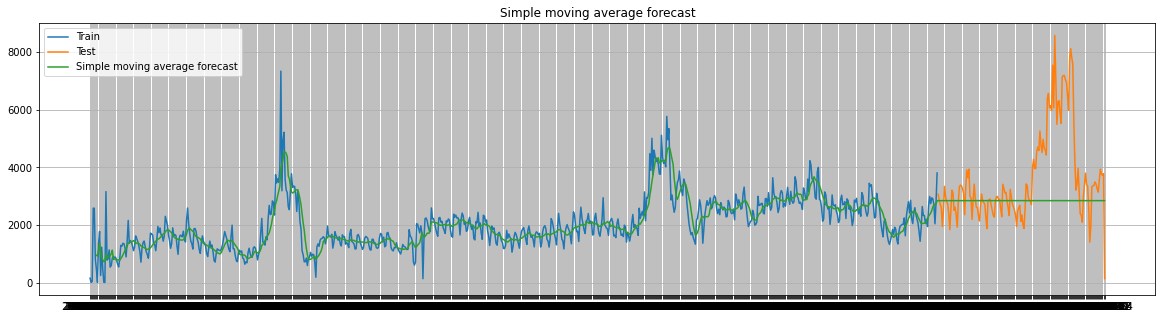

In [24]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['quantity'], label='Train')
plt.plot(test['quantity'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Simple moving average forecast')
plt.legend(loc = 'best')
plt.title('Simple moving average forecast')
plt.show()

In [25]:
rmse = np.sqrt(mean_squared_error(test['quantity'], y_hat_sma['sma_forecast'][train_len:])).round(3)
print('RMAE:%.3f' % rmse)

RMAE:1762.477


In [26]:
y_true = test['quantity'].values
y_pred = y_hat_sma['sma_forecast'][train_len:].values
mae = mean_absolute_error(y_true, y_pred )
print('MAE:%.3f' % mae)

MAE:1123.137


# Prophet

In [27]:
df_pro = df4.rename(columns={'date':'ds', 'quantity':'y'})
df_pro.head()

,ds,y
0,2019-06-01,154
1,2019-06-02,6
2,2019-06-03,37
3,2019-06-04,2583
4,2019-06-05,2584


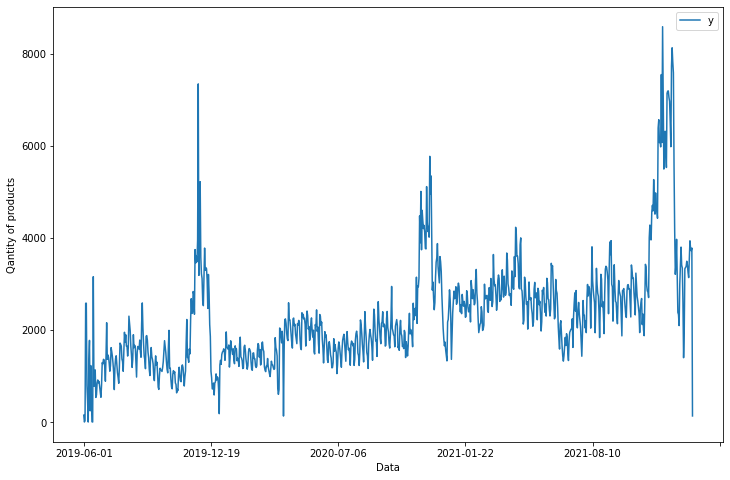

In [28]:
ax = df_pro.set_index('ds').plot(figsize =(12, 8))
ax.set_ylabel('Qantity of products')
ax.set_xlabel('Data')

plt.show()

In [29]:
model = Prophet(interval_width = 0.95)

In [30]:
model.fit(df_pro)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu6akekqp/6bxuxols.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu6akekqp/128kvrhm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26978', 'data', 'file=/tmp/tmpu6akekqp/6bxuxols.json', 'init=/tmp/tmpu6akekqp/128kvrhm.json', 'output', 'file=/tmp/tmpu6akekqp/prophet_modelc3r6z2rb/prophet_model-20221130233505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:35:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:35:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [31]:
future_dates = model.make_future_dataframe(periods = 365, freq='D')
future_dates.head()

,ds
0,2019-06-01
1,2019-06-02
2,2019-06-03
3,2019-06-04
4,2019-06-05


In [32]:
forcast = model.predict(future_dates)
forcast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-06-01,1196.163625,165.607430,2297.668738
1,2019-06-02,1764.719579,742.716487,2800.452606
2,2019-06-03,1892.940820,807.234834,3007.544028
3,2019-06-04,1669.293875,753.630086,2733.708980
4,2019-06-05,1562.432141,492.110443,2619.346965


In [33]:
forcast[-366:]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
957,2022-01-14,3881.352239,2618.450114,4689.207446,3881.352239,3881.352239,-219.747574,-219.747574,-219.747574,-225.256445,-225.256445,-225.256445,5.508870,5.508870,5.508870,0.0,0.0,0.0,3661.604665
958,2022-01-15,3886.646112,2576.909610,4544.460575,3886.646112,3886.646112,-360.884089,-360.884089,-360.884089,-406.526948,-406.526948,-406.526948,45.642859,45.642859,45.642859,0.0,0.0,0.0,3525.762022
959,2022-01-16,3891.939985,3221.802895,5100.797776,3891.939985,3891.944547,263.800076,263.800076,263.800076,183.273104,183.273104,183.273104,80.526972,80.526972,80.526972,0.0,0.0,0.0,4155.740061
960,2022-01-17,3897.233857,3297.937838,5318.322515,3897.065277,3897.371375,445.405025,445.405025,445.405025,335.639453,335.639453,335.639453,109.765571,109.765571,109.765571,0.0,0.0,0.0,4342.638882
961,2022-01-18,3902.527730,3164.612918,5134.500312,3902.183508,3902.934363,271.979743,271.979743,271.979743,138.878576,138.878576,138.878576,133.101167,133.101167,133.101167,0.0,0.0,0.0,4174.507473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318,2023-01-10,5792.440350,4507.553592,6894.222061,5169.526798,6421.265309,-69.876081,-69.876081,-69.876081,138.878576,138.878576,138.878576,-208.754657,-208.754657,-208.754657,0.0,0.0,0.0,5722.564269
1319,2023-01-11,5797.734223,4621.392014,6905.946195,5171.292695,6429.325316,-92.404000,-92.404000,-92.404000,61.431483,61.431483,61.431483,-153.835483,-153.835483,-153.835483,0.0,0.0,0.0,5705.330223
1320,2023-01-12,5803.028096,4454.516975,6773.089156,5172.778336,6437.385323,-188.447405,-188.447405,-188.447405,-87.439223,-87.439223,-87.439223,-101.008182,-101.008182,-101.008182,0.0,0.0,0.0,5614.580691
1321,2023-01-13,5808.321969,4373.369377,6718.566813,5174.263976,6445.445330,-276.472396,-276.472396,-276.472396,-225.256445,-225.256445,-225.256445,-51.215951,-51.215951,-51.215951,0.0,0.0,0.0,5531.849573


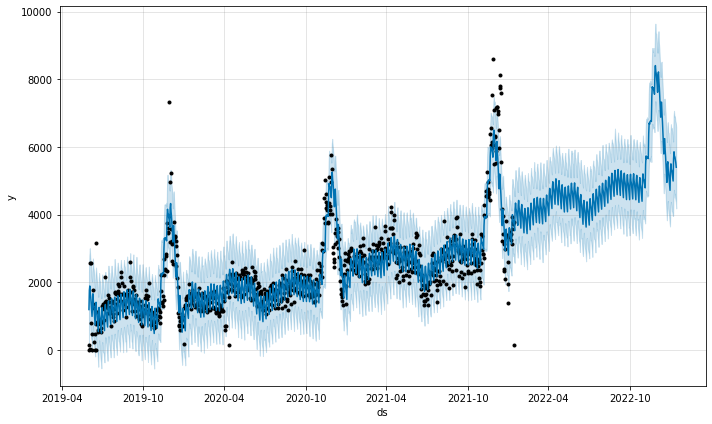

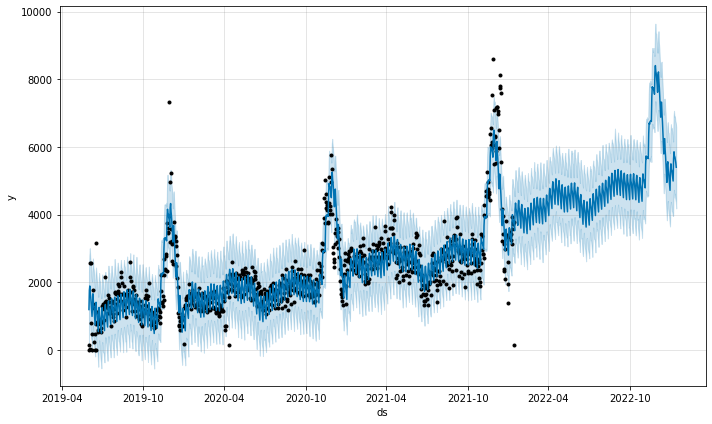

In [34]:
model.plot(forcast, uncertainty=True)

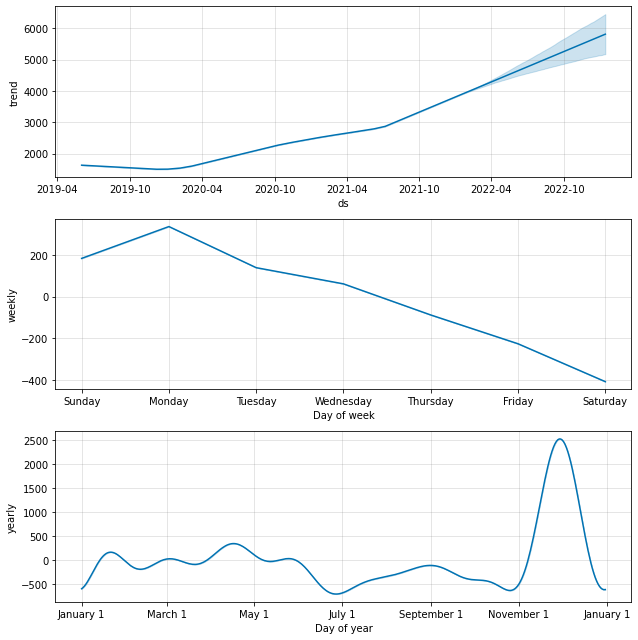

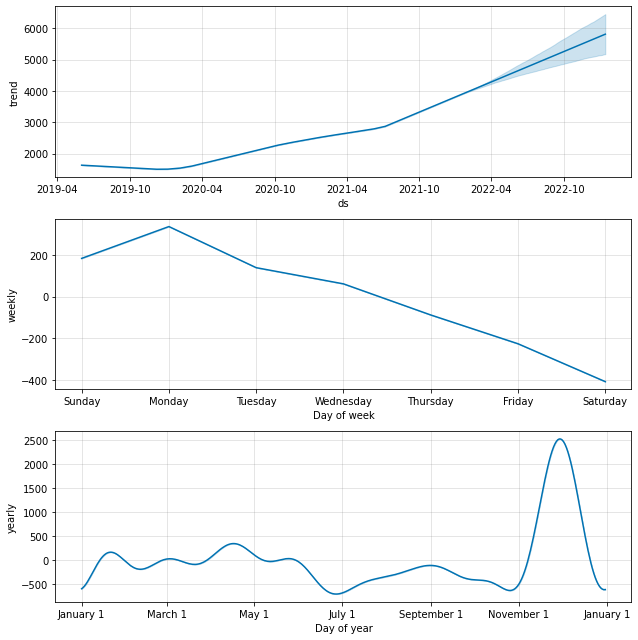

In [35]:
model.plot_components(forcast)

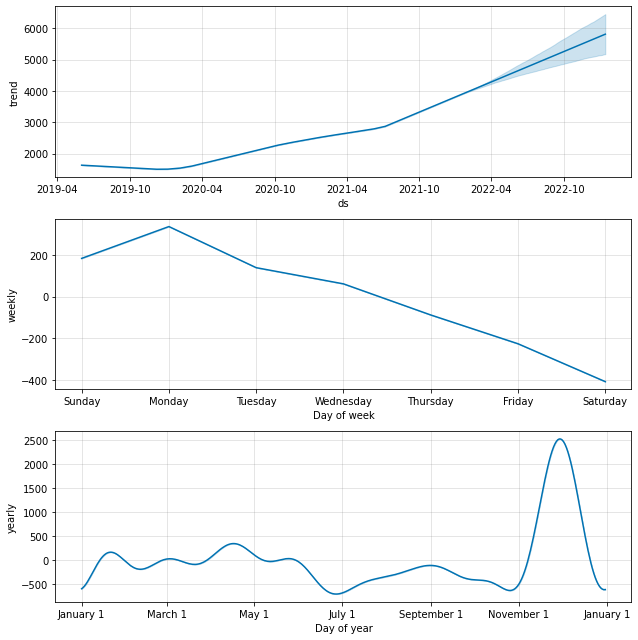

In [36]:
fig1 = model.plot_components(forcast)

In [37]:
## Evaluation 
y_true = df_pro['y'].values
y_pred = forcast['yhat'].values[:958]
mae = mean_absolute_error(y_true, y_pred )
print('MAE:%.3f' % mae)

MAE:338.301


In [38]:
df4.shape

(958, 2)

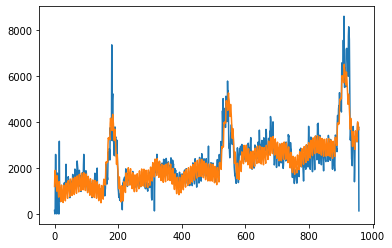

In [39]:
plt.plot(df_pro['y'].values)
plt.plot(forcast['yhat'].values[:958])

In [40]:
## adding changing pionts 


# Arima

In [41]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.stattools import acf

In [42]:
df4['date'] = pd.to_datetime(df4['date'], utc=True)

df4.set_index('date', inplace=True)

print(df4.index.date)
print(df4)

[datetime.date(2019, 6, 1) datetime.date(2019, 6, 2)
 datetime.date(2019, 6, 3) datetime.date(2019, 6, 4)
 datetime.date(2019, 6, 5) datetime.date(2019, 6, 6)
 datetime.date(2019, 6, 7) datetime.date(2019, 6, 8)
 datetime.date(2019, 6, 10) datetime.date(2019, 6, 11)
 datetime.date(2019, 6, 12) datetime.date(2019, 6, 13)
 datetime.date(2019, 6, 14) datetime.date(2019, 6, 15)
 datetime.date(2019, 6, 16) datetime.date(2019, 6, 17)
 datetime.date(2019, 6, 18) datetime.date(2019, 6, 19)
 datetime.date(2019, 6, 20) datetime.date(2019, 6, 21)
 datetime.date(2019, 6, 22) datetime.date(2019, 6, 23)
 datetime.date(2019, 6, 24) datetime.date(2019, 6, 25)
 datetime.date(2019, 6, 26) datetime.date(2019, 6, 27)
 datetime.date(2019, 6, 28) datetime.date(2019, 6, 29)
 datetime.date(2019, 6, 30) datetime.date(2019, 7, 1)
 datetime.date(2019, 7, 2) datetime.date(2019, 7, 3)
 datetime.date(2019, 7, 4) datetime.date(2019, 7, 5)
 datetime.date(2019, 7, 6) datetime.date(2019, 7, 7)
 datetime.date(2019, 7, 8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [43]:
ts = df4
ts.head()
ts.shape

(958, 1)

<Figure size 1008x288 with 0 Axes>

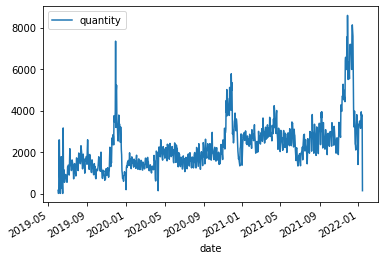

In [44]:
plt.figure(figsize=(14,4))
ts.plot()

<Figure size 1008x288 with 0 Axes>

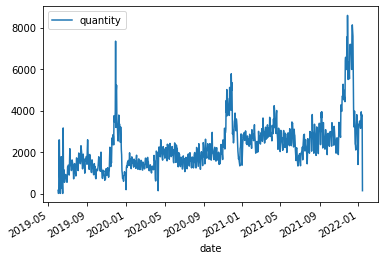

In [45]:
7# Resample data by monthly
plt.figure(figsize=(14,4))
ts.plot()

Perfom Dickey fuller test
Test Statistic                  -3.837632
p-value                          0.002545
#Lags Used                      21.000000
Number of Observations Used    936.000000
Critical Value (1%)             -3.437356
Critical Value (5%)             -2.864633
Critical Value (10%)            -2.568417
dtype: float64


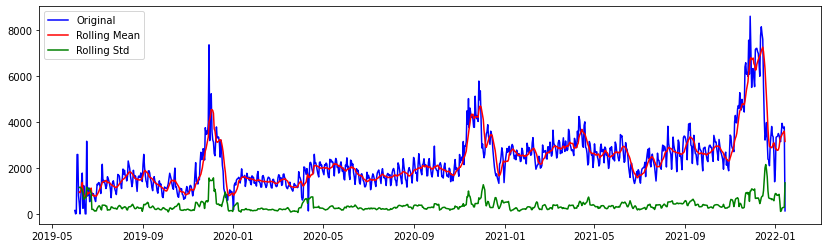

In [46]:
def test_stationarity(timeseries):
    
    #rolling statics
    rol_mean = timeseries.rolling(window = 7).mean()
    rol_std = timeseries.rolling(window = 7).std()
    
    #plot rolling statistics
    plt.figure(figsize=(14,4))
    plt.plot(ts, color = 'b', label = 'Original')
    plt.plot(rol_mean, color = 'r', label = 'Rolling Mean')
    plt.plot(rol_std, color = 'g', label = 'Rolling Std')
    plt.legend(loc='best')
    
    # Dickey fuller test
    print('Perfom Dickey fuller test')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(ts)

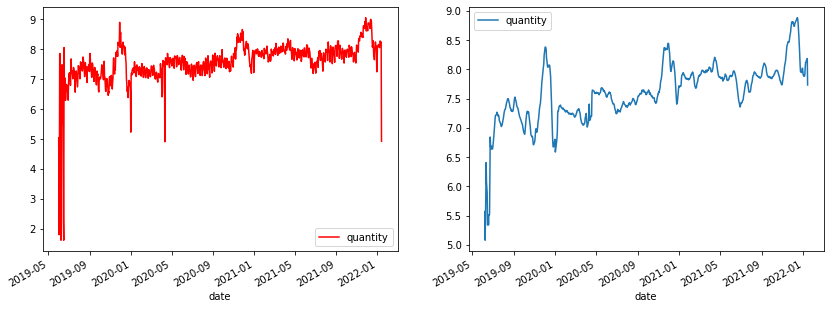

In [47]:
### Log

fig,ax = plt.subplots(1,2,figsize=(14,5))
ax1, ax2 = ax.flatten()

ts_log = np.log(ts)
ts_log.plot(ax=ax1, label = 'Log',color = 'r')
ax1.legend(loc = 'best')

ts_ma = ts_log.rolling(7).mean()
ts_ma.plot(ax = ax2, label = 'mean')
ax2.legend(loc = 'best')

<Figure size 1008x288 with 0 Axes>

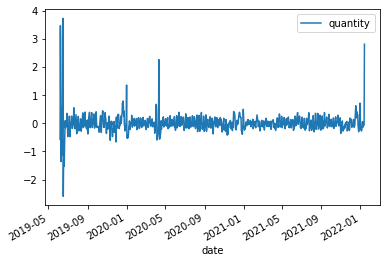

In [48]:
plt.figure(figsize=(14,4))
ts_dif = ts_ma - ts_log
ts_dif = ts_dif.dropna() # fill na
ts_dif.plot()

Perfom Dickey fuller test
Test Statistic                -7.048478e+00
p-value                        5.606088e-10
#Lags Used                     2.100000e+01
Number of Observations Used    9.300000e+02
Critical Value (1%)           -3.437401e+00
Critical Value (5%)           -2.864653e+00
Critical Value (10%)          -2.568427e+00
dtype: float64


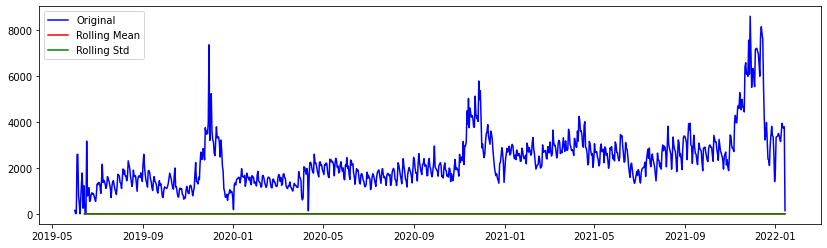

In [49]:
test_stationarity(ts_dif)

<Figure size 1008x288 with 0 Axes>

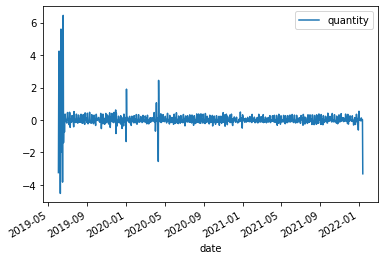

In [50]:
# Difference 
ts_log_dif = ts_log - ts_log.shift()
plt.figure(figsize=(14,4))
ts_log_dif.plot()

Perfom Dickey fuller test
Test Statistic                -9.628839e+00
p-value                        1.632802e-16
#Lags Used                     1.300000e+01
Number of Observations Used    9.430000e+02
Critical Value (1%)           -3.437304e+00
Critical Value (5%)           -2.864610e+00
Critical Value (10%)          -2.568405e+00
dtype: float64


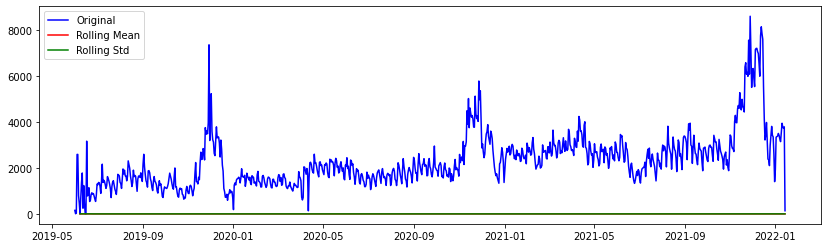

In [51]:
ts_log_dif.dropna(inplace = True)
test_stationarity(ts_log_dif)

In [52]:
from statsmodels.graphics.tsaplots import acf, pacf
# ACF
lag_acf = acf(ts_dif,nlags=7)
#PACF
lag_pacf = pacf(ts_dif, nlags=7, method='ols')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


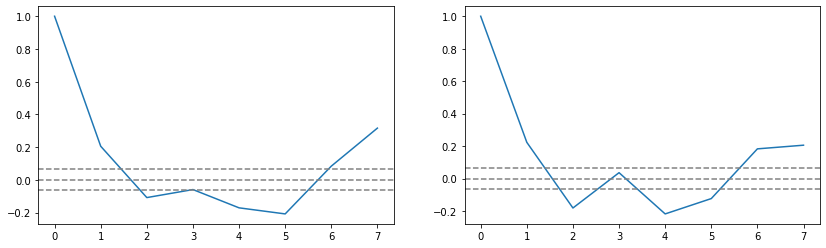

In [53]:
fig,ax = plt.subplots(1,2, figsize=(14,4))
ax1, ax2 = ax.flatten()
ax1.plot(lag_acf)
ax1.axhline(y=0,linestyle='--',color= 'gray')
ax1.axhline(y= - 1.96/np.sqrt(len(ts_dif)), linestyle='--',color= 'gray')
ax1.axhline(y=  1.96/np.sqrt(len(ts_dif)), linestyle='--',color= 'gray')

ax2.plot(lag_pacf,)
ax2.axhline(y=0,linestyle = '--', color = 'gray')
ax2.axhline(y = -1.96/np.sqrt(len(ts_dif)), linestyle = '--', color = 'gray')
ax2.axhline(y = 1.96/np.sqrt(len(ts_dif)), linestyle = '--', color = 'gray')

In [54]:
model = ARIMA(ts, order = (1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                  958
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7268.665
Date:                Wed, 30 Nov 2022   AIC                          14543.330
Time:                        23:35:13   BIC                          14557.922
Sample:                             0   HQIC                         14548.888
                                - 958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4494      0.038     11.855      0.000       0.375       0.524
ma.L1         -0.7558      0.029    -25.910      0.000      -0.813      -0.699
sigma2      2.332e+05   4232.778     55.097      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


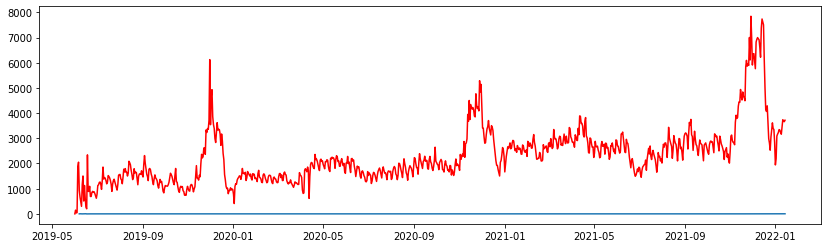

In [55]:
plt.figure(figsize=(14,4))
plt.plot(ts_dif)
plt.plot(model_fit.fittedvalues,color = 'r')

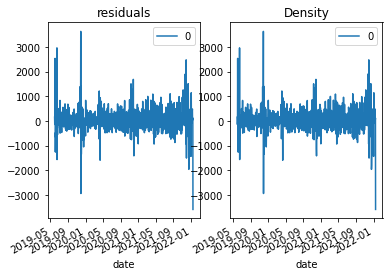

In [56]:
#plot residual error
residuals = pd.DataFrame(model_fit.resid)
fig, ax=plt.subplots(1, 2)
residuals.plot(title='residuals', ax=ax[0])
residuals.plot(title='Density', ax=ax[1])

In [57]:
# build model 
print(ts.shape)
train = ts[:900]
test = ts[900:]
print(train.shape,test.shape)

(958, 1)
(900, 1) (58, 1)


In [58]:
model = ARIMA(train, order=(1,2,0))
fitted = model.fit()
fitted.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               quantity   No. Observations:                  900
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -7034.677
Date:                Wed, 30 Nov 2022   AIC                          14073.353
Time:                        23:35:14   BIC                          14082.953
Sample:                             0   HQIC                         14077.021
                                - 900                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5305      0.013    -39.525      0.000      -0.557      -0.504
sigma2      3.734e+05   6860.692     54.425      0.000     3.6e+05    3.87e+05
===================================================================================
Ljung-Box (L1) (Q):                  45.64   Jarque-Bera (JB):              8720.50
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                            -0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
start = len(train)
end=len(train)+len(test)-1
pred = fitted.predict(start=start, end=end, type='levels')
pred.index=ts.index[start:end+1]
print(pred)

date
2021-11-18 00:00:00+00:00     5067.719710
2021-11-19 00:00:00+00:00     5353.868493
2021-11-20 00:00:00+00:00     5535.814105
2021-11-21 00:00:00+00:00     5773.038198
2021-11-22 00:00:00+00:00     5980.937747
2021-11-23 00:00:00+00:00     6204.393600
2021-11-24 00:00:00+00:00     6419.597028
2021-11-25 00:00:00+00:00     6639.178265
2021-11-26 00:00:00+00:00     6856.437129
2021-11-27 00:00:00+00:00     7074.927983
2021-11-28 00:00:00+00:00     7292.765281
2021-11-29 00:00:00+00:00     7510.949283
2021-11-30 00:00:00+00:00     7728.949363
2021-12-01 00:00:00+00:00     7947.047011
2021-12-02 00:00:00+00:00     8165.092900
2021-12-03 00:00:00+00:00     8383.166246
2021-12-04 00:00:00+00:00     8601.225027
2021-12-05 00:00:00+00:00     8819.291535
2021-12-06 00:00:00+00:00     9037.353944
2021-12-07 00:00:00+00:00     9255.418527
2021-12-08 00:00:00+00:00     9473.481957
2021-12-09 00:00:00+00:00     9691.545998
2021-12-10 00:00:00+00:00     9909.609715
2021-12-11 00:00:00+00:00    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


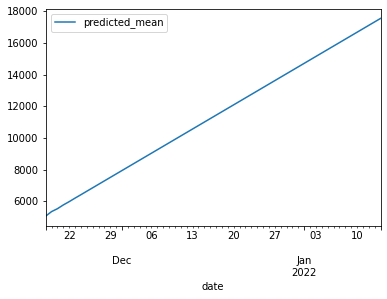

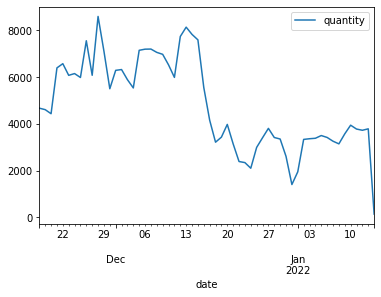

In [60]:
pred.plot(legend=True)
test.plot(legend=True)

In [61]:
start = len(train)
end=len(train)+len(test)-1
pred = model_fit.predict(start=start, end=end, type='levels')
pred.index=ts.index[start:end+1]
print(pred)

date
2021-11-18 00:00:00+00:00    4839.548990
2021-11-19 00:00:00+00:00    4656.948482
2021-11-20 00:00:00+00:00    4614.767896
2021-11-21 00:00:00+00:00    4490.963734
2021-11-22 00:00:00+00:00    5834.357996
2021-11-23 00:00:00+00:00    6094.136507
2021-11-24 00:00:00+00:00    5864.174286
2021-11-25 00:00:00+00:00    5966.203603
2021-11-26 00:00:00+00:00    5893.781803
2021-11-27 00:00:00+00:00    7003.055710
2021-11-28 00:00:00+00:00    6112.105022
2021-11-29 00:00:00+00:00    7846.479136
2021-11-30 00:00:00+00:00    6997.036941
2021-12-01 00:00:00+00:00    5909.188110
2021-12-02 00:00:00+00:00    6353.477846
2021-12-03 00:00:00+00:00    6359.608685
2021-12-04 00:00:00+00:00    6049.325178
2021-12-05 00:00:00+00:00    5763.425022
2021-12-06 00:00:00+00:00    6822.439533
2021-12-07 00:00:00+00:00    6933.022136
2021-12-08 00:00:00+00:00    6998.500006
2021-12-09 00:00:00+00:00    6947.252371
2021-12-10 00:00:00+00:00    6914.769674
2021-12-11 00:00:00+00:00    6614.707254
2021-12-12 

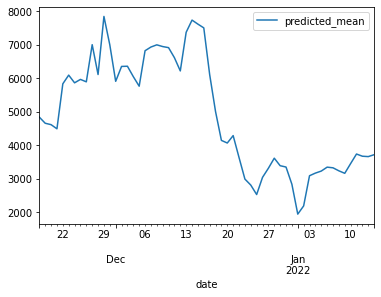

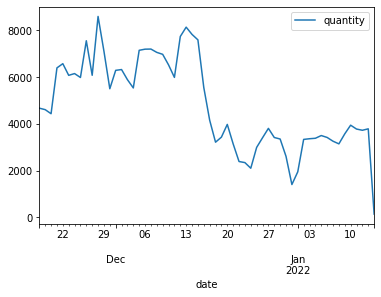

In [62]:
pred.plot(legend=True)
test.plot(legend=True)

In [63]:
print('MAE:', metrics.mean_absolute_error(test, pred))
print('MSE:', metrics.mean_squared_error(test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test, pred)))

MAE: 661.48029597661
MSE: 968266.0747517742
RMSE: 984.0051192711215


In [64]:
df.columns

Index(['Unnamed: 0', 'order_id', 'date', 'quantity', 'unit_price_vat_excl',
       'department', 'store_ca', 'country', 'days_of_week', 'month', 'days',
       'sales', 'name'],
      dtype='object')

# ML Modelling 

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [66]:
data = df4

In [67]:
df4

,quantity
date,
2019-06-01 00:00:00+00:00,154
2019-06-02 00:00:00+00:00,6
2019-06-03 00:00:00+00:00,37
2019-06-04 00:00:00+00:00,2583
2019-06-05 00:00:00+00:00,2584
...,...
2022-01-10 00:00:00+00:00,3938
2022-01-11 00:00:00+00:00,3773
2022-01-12 00:00:00+00:00,3721


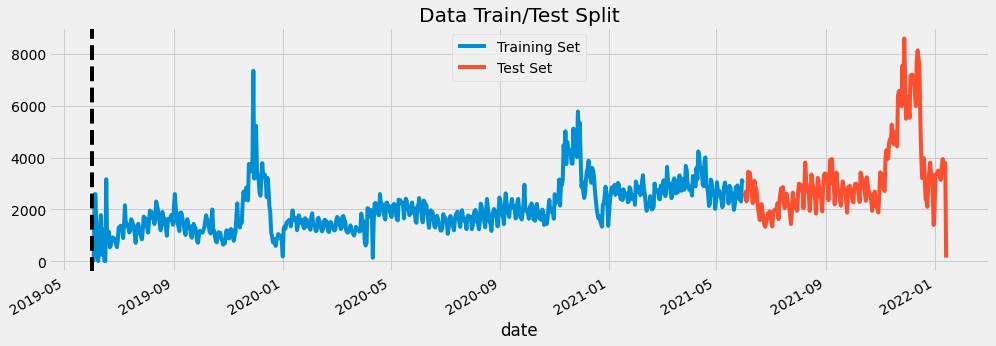

In [68]:
# Split data 
train = data.loc[data.index < '06-01-2021']
test = data.loc[data.index >= '06-01-2021']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('06-01-2019', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [69]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

data = create_features(data)

In [70]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'quantity'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# Model 

In [71]:
# X_train=X_train.drop('const', axis=1)

In [72]:
## XG Broost 
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[23:35:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2162.81	validation_1-rmse:3517.96
[100]	validation_0-rmse:922.496	validation_1-rmse:2063.06
[200]	validation_0-rmse:526.402	validation_1-rmse:1588.33
[300]	validation_0-rmse:411.241	validation_1-rmse:1442.6
[400]	validation_0-rmse:365.161	validation_1-rmse:1375.85
[500]	validation_0-rmse:338.407	validation_1-rmse:1336.2
[600]	validation_0-rmse:321.224	validation_1-rmse:1315.95
[700]	validation_0-rmse:309.049	validation_1-rmse:1301.56
[800]	validation_0-rmse:301.758	validation_1-rmse:1294.99
[900]	validation_0-rmse:293.459	validation_1-rmse:1289.01
[999]	validation_0-rmse:285.352	validation_1-rmse:1283.96


XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, n_estimators=1000)

In [73]:
test['prediction'] = reg.predict(X_test)

In [74]:
score = np.sqrt(mean_squared_error(test['quantity'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1283.96


In [75]:
print(reg.score(X_train,y_train)) 
print(reg.score(X_test,y_test))

0.8961925761984818
0.25050876890317186


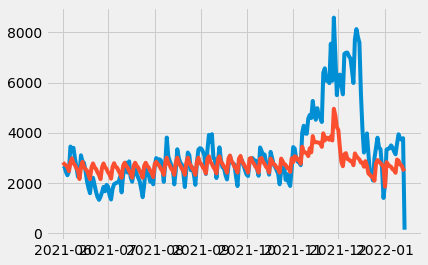

In [76]:
plt.plot(test['quantity'])
plt.plot(test['prediction'])

In [77]:
# 1, grid Search 

In [78]:
##Linear Regression
from sklearn.linear_model import LinearRegression

linReg = LinearRegression()
linReg.fit(X_train, y_train)

LinearRegression()

In [79]:
print('R2 of linear Regression:', linReg.score(X_train, y_train))

R2 of linear Regression: 0.40180952777676515


In [80]:
y_pred = linReg.predict(X_test)

In [81]:
print('MAE:', metrics.mean_absolute_error(y_test, linReg.predict(X_test)))
print('MSE:', metrics.mean_squared_error(y_test, linReg.predict(X_test)))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, linReg.predict(X_test))))

MAE: 1000.9059489620104
MSE: 1768025.9189380314
RMSE: 1329.6713574932835


In [82]:
print(linReg.score(X_train,y_train)) 
print(linReg.score(X_test,y_test))

0.40180952777676515
0.19619445077613362


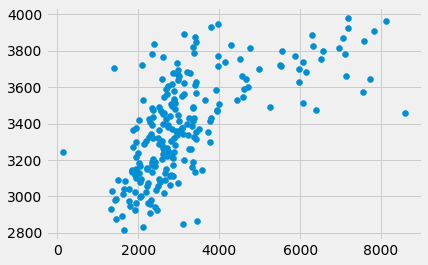

In [83]:
plt.scatter(y_test, linReg.predict(X_test))

In [84]:
import statsmodels.api as sm
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
print(model.summary)

<bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7f83c7fadcd0>>


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [85]:
# 2, Grideian Decinet 


In [86]:
X_train=X_train.drop('const', axis=1)

In [87]:
# DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor


cf = DecisionTreeRegressor(criterion='squared_error',
                                splitter='best',
                                max_depth=None,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0,
                                max_features=None,
                                random_state=None,
                                max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                ccp_alpha=0.0)

cf.fit(X_train, y_train)
prediction = cf.predict(X_test)

In [88]:
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 940.8508771929825
MSE: 2375684.0263157897
RMSE: 1541.3254122072308


In [89]:
print(cf.score(X_train,y_train)) 
print(cf.score(X_test,y_test))

1.0
-0.08006787858750819


In [90]:
# 3, grid Search 

In [91]:
# Random Forest

from sklearn.ensemble import RandomForestRegressor
RForest = RandomForestRegressor()
RForest.fit(X_train,y_train)
print(RForest.score(X_train,y_train)) 
print(RForest.score(X_test,y_test))

0.9747536979980747
0.0838998634011191


In [92]:
print('MAE:', metrics.mean_absolute_error(y_test, RForest.predict(X_test)))
print('MSE:', metrics.mean_squared_error(y_test, RForest.predict(X_test)))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, RForest.predict(X_test))))

MAE: 882.8125438596492
MSE: 2015025.633268421
RMSE: 1419.515985562833


In [93]:
# 4. grid Search 

In [94]:
#KNN
from sklearn import neighbors
from math import sqrt

Knn = neighbors.KNeighborsRegressor()
Knn.fit(X_train, y_train)  

KNeighborsRegressor()

In [95]:
print('MAE:', metrics.mean_absolute_error(y_test, Knn.predict(X_test)))
print('MSE:', metrics.mean_squared_error(y_test, Knn.predict(X_test)))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, Knn.predict(X_test))))

MAE: 1260.5543859649124
MSE: 2372400.3442105264
RMSE: 1540.2598300970283


In [96]:
print(Knn.score(X_train,y_train)) 
print(Knn.score(X_test,y_test))

0.6441122620012053
-0.07857500347191992


In [97]:
# 5, grid Search 

In [98]:
#LSTM
import tensorflow as tf

In [99]:
import os
import pandas as pd
import numpy as np

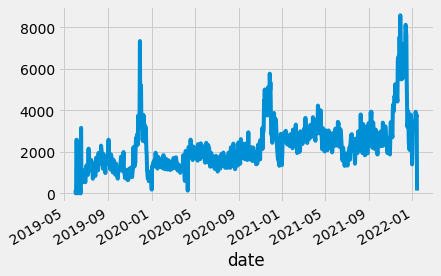

In [100]:
df_t = data['quantity']
df_t.plot()

In [101]:
def df_to_X_y(df, window_size=7):
  df_as_np = df.to_numpy()
  X=[]
  y=[]
  for i in range(len(df_as_np)-window_size):
    row=[[a] for a in df_as_np[i:i+7]]
    X.append(row)
    label=df_as_np[i+7]
    y.append(label)
  return np.array(X), np.array(y)

In [102]:
df_q = data['quantity']

In [103]:
WINDOW_SIZE = 7
X, y = df_to_X_y(df_q, WINDOW_SIZE)
X.shape, y.shape

((951, 7, 1), (951,))

In [104]:
# split Train validation
X_train, y_tarin = X[:800], y[:800] 
X_val, y_val = X[800:900], y[800:900] 
X_test, y_test = X[800:], y[800:] 
X_train.shape, y_tarin.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((800, 7, 1), (800,), (100, 7, 1), (100,), (151, 7, 1), (151,))

In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, MAE
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [106]:
model1 = Sequential()
model1.add(InputLayer((7, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [107]:
cf = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate =0.01), metrics=[RootMeanSquaredError()])

In [108]:
model1.fit(X_train, y_tarin, validation_data = (X_val, y_val), epochs=500, callbacks=[cf])

Epoch 1/500
17/25 [===================>..........] - ETA: 0s - loss: 4891885.5000 - root_mean_squared_error: 2211.7607

25/25 [==============================] - 9s 267ms/step - loss: 4875590.0000 - root_mean_squared_error: 2208.0737 - val_loss: 10849087.0000 - val_root_mean_squared_error: 3293.7952
Epoch 2/500
24/25 [===========================>..] - ETA: 0s - loss: 4878524.0000 - root_mean_squared_error: 2208.7380

25/25 [==============================] - 6s 238ms/step - loss: 4822493.5000 - root_mean_squared_error: 2196.0176 - val_loss: 10703141.0000 - val_root_mean_squared_error: 3271.5654
Epoch 3/500
16/25 [==================>...........] - ETA: 0s - loss: 4988238.0000 - root_mean_squared_error: 2233.4363

25/25 [==============================] - 6s 265ms/step - loss: 4650582.0000 - root_mean_squared_error: 2156.5208 - val_loss: 10266250.0000 - val_root_mean_squared_error: 3204.0989
Epoch 4/500
19/25 [=====================>........] - ETA: 0s - loss: 4280147.5000 - root_mean_squared_error: 2068.8518

25/25 [==============================] - 6s 229ms/step - loss: 4264966.0000 - root_mean_squared_error: 2065.1794 - val_loss: 9452817.0000 - val_root_mean_squared_error: 3074.5435
Epoch 5/500
19/25 [=====================>........] - ETA: 0s - loss: 3769030.7500 - root_mean_squared_error: 1941.3992

25/25 [==============================] - 6s 260ms/step - loss: 3661179.7500 - root_mean_squared_error: 1913.4209 - val_loss: 8331085.5000 - val_root_mean_squared_error: 2886.3621
Epoch 6/500
24/25 [===========================>..] - ETA: 0s - loss: 2922909.2500 - root_mean_squared_error: 1709.6517

25/25 [==============================] - 6s 241ms/step - loss: 2940232.2500 - root_mean_squared_error: 1714.7106 - val_loss: 7023940.0000 - val_root_mean_squared_error: 2650.2717
Epoch 7/500
22/25 [=========================>....] - ETA: 0s - loss: 2206086.2500 - root_mean_squared_error: 1485.2899

25/25 [==============================] - 7s 280ms/step - loss: 2222653.7500 - root_mean_squared_error: 1490.8567 - val_loss: 5753727.5000 - val_root_mean_squared_error: 2398.6929
Epoch 8/500
24/25 [===========================>..] - ETA: 0s - loss: 1618162.8750 - root_mean_squared_error: 1272.0703

25/25 [==============================] - 6s 243ms/step - loss: 1629041.6250 - root_mean_squared_error: 1276.3391 - val_loss: 4620649.5000 - val_root_mean_squared_error: 2149.5696
Epoch 9/500
18/25 [====================>.........] - ETA: 0s - loss: 1312126.6250 - root_mean_squared_error: 1145.4810

25/25 [==============================] - 9s 357ms/step - loss: 1227741.7500 - root_mean_squared_error: 1108.0350 - val_loss: 3838489.2500 - val_root_mean_squared_error: 1959.2063
Epoch 10/500
25/25 [==============================] - ETA: 0s - loss: 976526.0000 - root_mean_squared_error: 988.1933

25/25 [==============================] - 7s 280ms/step - loss: 976526.0000 - root_mean_squared_error: 988.1933 - val_loss: 3278085.7500 - val_root_mean_squared_error: 1810.5485
Epoch 11/500
23/25 [==========================>...] - ETA: 0s - loss: 863710.8125 - root_mean_squared_error: 929.3604

25/25 [==============================] - 6s 238ms/step - loss: 844978.3125 - root_mean_squared_error: 919.2270 - val_loss: 2781517.0000 - val_root_mean_squared_error: 1667.7881
Epoch 12/500
25/25 [==============================] - 0s 9ms/step - loss: 844207.0625 - root_mean_squared_error: 918.8074 - val_loss: 3112341.0000 - val_root_mean_squared_error: 1764.1829
Epoch 13/500
25/25 [==============================] - 0s 10ms/step - loss: 854478.1875 - root_mean_squared_error: 924.3799 - val_loss: 3113035.5000 - val_root_mean_squared_error: 1764.3796
Epoch 14/500
20/25 [=======================>......] - ETA: 0s - loss: 809245.8750 - root_mean_squared_error: 899.5809

25/25 [==============================] - 7s 283ms/step - loss: 810345.0625 - root_mean_squared_error: 900.1917 - val_loss: 2689765.5000 - val_root_mean_squared_error: 1640.0504
Epoch 15/500
25/25 [==============================] - 0s 9ms/step - loss: 759674.0625 - root_mean_squared_error: 871.5928 - val_loss: 2731378.0000 - val_root_mean_squared_error: 1652.6881
Epoch 16/500
25/25 [==============================] - 0s 9ms/step - loss: 818170.8750 - root_mean_squared_error: 904.5280 - val_loss: 3011978.0000 - val_root_mean_squared_error: 1735.5051
Epoch 17/500
25/25 [==============================] - 0s 9ms/step - loss: 983037.1875 - root_mean_squared_error: 991.4823 - val_loss: 4140729.2500 - val_root_mean_squared_error: 2034.8782
Epoch 18/500
25/25 [==============================] - 0s 8ms/step - loss: 1508102.1250 - root_mean_squared_error: 1228.0481 - val_loss: 6125990.0000 - val_root_mean_squared_error: 2475.0737
Epoch 19/500
25/25 [==============================] - 0s 8ms/step - l

25/25 [==============================] - 6s 235ms/step - loss: 771133.3750 - root_mean_squared_error: 878.1420 - val_loss: 2508721.2500 - val_root_mean_squared_error: 1583.8943
Epoch 22/500
25/25 [==============================] - 0s 9ms/step - loss: 766079.8125 - root_mean_squared_error: 875.2598 - val_loss: 3694642.0000 - val_root_mean_squared_error: 1922.1451
Epoch 23/500
25/25 [==============================] - 0s 8ms/step - loss: 929364.7500 - root_mean_squared_error: 964.0356 - val_loss: 3001780.7500 - val_root_mean_squared_error: 1732.5648
Epoch 24/500
25/25 [==============================] - 0s 9ms/step - loss: 803440.6250 - root_mean_squared_error: 896.3485 - val_loss: 2649480.2500 - val_root_mean_squared_error: 1627.7224
Epoch 25/500
25/25 [==============================] - ETA: 0s - loss: 742174.1875 - root_mean_squared_error: 861.4953

25/25 [==============================] - 6s 243ms/step - loss: 742174.1875 - root_mean_squared_error: 861.4953 - val_loss: 2373509.7500 - val_root_mean_squared_error: 1540.6199
Epoch 26/500
25/25 [==============================] - 0s 8ms/step - loss: 742865.8125 - root_mean_squared_error: 861.8966 - val_loss: 2528139.7500 - val_root_mean_squared_error: 1590.0125
Epoch 27/500
25/25 [==============================] - 0s 7ms/step - loss: 794884.9375 - root_mean_squared_error: 891.5632 - val_loss: 2620363.0000 - val_root_mean_squared_error: 1618.7535
Epoch 28/500
18/25 [====================>.........] - ETA: 0s - loss: 782564.6875 - root_mean_squared_error: 884.6269

25/25 [==============================] - 7s 277ms/step - loss: 737304.2500 - root_mean_squared_error: 858.6642 - val_loss: 2313945.2500 - val_root_mean_squared_error: 1521.1658
Epoch 29/500
20/25 [=======================>......] - ETA: 0s - loss: 717646.3125 - root_mean_squared_error: 847.1401

25/25 [==============================] - 6s 229ms/step - loss: 721584.5625 - root_mean_squared_error: 849.4614 - val_loss: 2219584.7500 - val_root_mean_squared_error: 1489.8270
Epoch 30/500
19/25 [=====================>........] - ETA: 0s - loss: 649700.3125 - root_mean_squared_error: 806.0399

25/25 [==============================] - 6s 240ms/step - loss: 719970.3750 - root_mean_squared_error: 848.5107 - val_loss: 2204725.0000 - val_root_mean_squared_error: 1484.8317
Epoch 31/500
25/25 [==============================] - ETA: 0s - loss: 719572.0625 - root_mean_squared_error: 848.2759

25/25 [==============================] - 7s 291ms/step - loss: 719572.0625 - root_mean_squared_error: 848.2759 - val_loss: 2200853.0000 - val_root_mean_squared_error: 1483.5272
Epoch 32/500
20/25 [=======================>......] - ETA: 0s - loss: 722919.3750 - root_mean_squared_error: 850.2466

25/25 [==============================] - 6s 242ms/step - loss: 719119.1250 - root_mean_squared_error: 848.0089 - val_loss: 2191821.7500 - val_root_mean_squared_error: 1480.4802
Epoch 33/500
24/25 [===========================>..] - ETA: 0s - loss: 719651.7500 - root_mean_squared_error: 848.3229

25/25 [==============================] - 7s 274ms/step - loss: 719193.8125 - root_mean_squared_error: 848.0530 - val_loss: 2155807.0000 - val_root_mean_squared_error: 1468.2667
Epoch 34/500
25/25 [==============================] - 0s 8ms/step - loss: 726501.3750 - root_mean_squared_error: 852.3505 - val_loss: 2522386.0000 - val_root_mean_squared_error: 1588.2021
Epoch 35/500
25/25 [==============================] - 0s 9ms/step - loss: 725450.8750 - root_mean_squared_error: 851.7341 - val_loss: 2316350.5000 - val_root_mean_squared_error: 1521.9562
Epoch 36/500
25/25 [==============================] - 0s 10ms/step - loss: 716404.8750 - root_mean_squared_error: 846.4070 - val_loss: 2203439.2500 - val_root_mean_squared_error: 1484.3986
Epoch 37/500
25/25 [==============================] - 0s 9ms/step - loss: 715378.5000 - root_mean_squared_error: 845.8005 - val_loss: 2179309.5000 - val_root_mean_squared_error: 1476.2484
Epoch 38/500
25/25 [==============================] - 0s 8ms/step - lo

25/25 [==============================] - 6s 248ms/step - loss: 719964.3750 - root_mean_squared_error: 848.5071 - val_loss: 2148361.5000 - val_root_mean_squared_error: 1465.7290
Epoch 50/500
25/25 [==============================] - 0s 8ms/step - loss: 719350.0625 - root_mean_squared_error: 848.1451 - val_loss: 2192990.0000 - val_root_mean_squared_error: 1480.8748
Epoch 51/500
25/25 [==============================] - 0s 9ms/step - loss: 718292.2500 - root_mean_squared_error: 847.5212 - val_loss: 2194064.2500 - val_root_mean_squared_error: 1481.2374
Epoch 52/500
25/25 [==============================] - 0s 9ms/step - loss: 718193.0625 - root_mean_squared_error: 847.4627 - val_loss: 2186591.7500 - val_root_mean_squared_error: 1478.7129
Epoch 53/500
25/25 [==============================] - 0s 9ms/step - loss: 718165.4375 - root_mean_squared_error: 847.4464 - val_loss: 2187459.7500 - val_root_mean_squared_error: 1479.0063
Epoch 54/500
25/25 [==============================] - 0s 8ms/step - los

25/25 [==============================] - 6s 244ms/step - loss: 712895.1875 - root_mean_squared_error: 844.3312 - val_loss: 2136152.7500 - val_root_mean_squared_error: 1461.5583
Epoch 93/500
25/25 [==============================] - 0s 7ms/step - loss: 721291.1875 - root_mean_squared_error: 849.2886 - val_loss: 2439153.5000 - val_root_mean_squared_error: 1561.7789
Epoch 94/500
25/25 [==============================] - 0s 8ms/step - loss: 714100.5000 - root_mean_squared_error: 845.0447 - val_loss: 2194315.2500 - val_root_mean_squared_error: 1481.3221
Epoch 95/500
25/25 [==============================] - 0s 9ms/step - loss: 709364.0625 - root_mean_squared_error: 842.2375 - val_loss: 2166416.7500 - val_root_mean_squared_error: 1471.8752
Epoch 96/500
25/25 [==============================] - 0s 7ms/step - loss: 709414.6250 - root_mean_squared_error: 842.2676 - val_loss: 2199411.7500 - val_root_mean_squared_error: 1483.0414
Epoch 97/500
25/25 [==============================] - 0s 9ms/step - los

25/25 [==============================] - 7s 271ms/step - loss: 705792.3750 - root_mean_squared_error: 840.1145 - val_loss: 2121395.2500 - val_root_mean_squared_error: 1456.5010
Epoch 111/500
25/25 [==============================] - 0s 8ms/step - loss: 706337.7500 - root_mean_squared_error: 840.4390 - val_loss: 2219797.0000 - val_root_mean_squared_error: 1489.8983
Epoch 112/500
25/25 [==============================] - 0s 8ms/step - loss: 706530.5000 - root_mean_squared_error: 840.5537 - val_loss: 2148189.0000 - val_root_mean_squared_error: 1465.6702
Epoch 113/500
25/25 [==============================] - 0s 7ms/step - loss: 704848.9375 - root_mean_squared_error: 839.5528 - val_loss: 2150938.0000 - val_root_mean_squared_error: 1466.6077
Epoch 114/500
25/25 [==============================] - 0s 7ms/step - loss: 704474.9375 - root_mean_squared_error: 839.3301 - val_loss: 2161829.0000 - val_root_mean_squared_error: 1470.3159
Epoch 115/500
25/25 [==============================] - 0s 7ms/step 

25/25 [==============================] - 6s 239ms/step - loss: 699367.0625 - root_mean_squared_error: 836.2817 - val_loss: 2113747.5000 - val_root_mean_squared_error: 1453.8733
Epoch 170/500
25/25 [==============================] - 0s 8ms/step - loss: 699682.8750 - root_mean_squared_error: 836.4705 - val_loss: 2162694.0000 - val_root_mean_squared_error: 1470.6101
Epoch 171/500
25/25 [==============================] - 0s 8ms/step - loss: 701601.1250 - root_mean_squared_error: 837.6163 - val_loss: 2223387.7500 - val_root_mean_squared_error: 1491.1029
Epoch 172/500
25/25 [==============================] - 0s 7ms/step - loss: 699070.5625 - root_mean_squared_error: 836.1044 - val_loss: 2131350.0000 - val_root_mean_squared_error: 1459.9144
Epoch 173/500
25/25 [==============================] - 0s 8ms/step - loss: 699449.1250 - root_mean_squared_error: 836.3307 - val_loss: 2158578.7500 - val_root_mean_squared_error: 1469.2102
Epoch 174/500
25/25 [==============================] - 0s 8ms/step 

25/25 [==============================] - 6s 269ms/step - loss: 698045.2500 - root_mean_squared_error: 835.4910 - val_loss: 2108976.0000 - val_root_mean_squared_error: 1452.2314
Epoch 276/500
25/25 [==============================] - 0s 8ms/step - loss: 700421.4375 - root_mean_squared_error: 836.9119 - val_loss: 2207258.7500 - val_root_mean_squared_error: 1485.6846
Epoch 277/500
25/25 [==============================] - 0s 10ms/step - loss: 697434.3750 - root_mean_squared_error: 835.1254 - val_loss: 2118216.2500 - val_root_mean_squared_error: 1455.4093
Epoch 278/500
25/25 [==============================] - 0s 9ms/step - loss: 698425.8125 - root_mean_squared_error: 835.7188 - val_loss: 2147929.5000 - val_root_mean_squared_error: 1465.5817
Epoch 279/500
25/25 [==============================] - 0s 9ms/step - loss: 698060.6250 - root_mean_squared_error: 835.5002 - val_loss: 2188013.5000 - val_root_mean_squared_error: 1479.1935
Epoch 280/500
25/25 [==============================] - 0s 9ms/step

25/25 [==============================] - 6s 241ms/step - loss: 697575.8125 - root_mean_squared_error: 835.2100 - val_loss: 2108481.0000 - val_root_mean_squared_error: 1452.0609
Epoch 332/500
25/25 [==============================] - 0s 8ms/step - loss: 697827.2500 - root_mean_squared_error: 835.3605 - val_loss: 2135259.7500 - val_root_mean_squared_error: 1461.2528
Epoch 333/500
25/25 [==============================] - 0s 9ms/step - loss: 697543.6250 - root_mean_squared_error: 835.1908 - val_loss: 2178072.7500 - val_root_mean_squared_error: 1475.8295
Epoch 334/500
25/25 [==============================] - 0s 9ms/step - loss: 697842.3125 - root_mean_squared_error: 835.3696 - val_loss: 2166218.2500 - val_root_mean_squared_error: 1471.8079
Epoch 335/500
25/25 [==============================] - 0s 9ms/step - loss: 698024.8750 - root_mean_squared_error: 835.4788 - val_loss: 2154885.0000 - val_root_mean_squared_error: 1467.9526
Epoch 336/500
25/25 [==============================] - 0s 8ms/step 

25/25 [==============================] - 6s 243ms/step - loss: 876208.0000 - root_mean_squared_error: 936.0598 - val_loss: 2047157.2500 - val_root_mean_squared_error: 1430.7891
Epoch 495/500
25/25 [==============================] - 0s 8ms/step - loss: 735446.7500 - root_mean_squared_error: 857.5819 - val_loss: 2315382.0000 - val_root_mean_squared_error: 1521.6379
Epoch 496/500
25/25 [==============================] - 0s 9ms/step - loss: 718667.0625 - root_mean_squared_error: 847.7423 - val_loss: 2257206.0000 - val_root_mean_squared_error: 1502.4000
Epoch 497/500
25/25 [==============================] - 0s 9ms/step - loss: 703348.3125 - root_mean_squared_error: 838.6586 - val_loss: 2149644.5000 - val_root_mean_squared_error: 1466.1666
Epoch 498/500
25/25 [==============================] - 0s 9ms/step - loss: 698020.0625 - root_mean_squared_error: 835.4760 - val_loss: 2160199.2500 - val_root_mean_squared_error: 1469.7616
Epoch 499/500
25/25 [==============================] - 0s 9ms/step 

In [109]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [110]:
#Train

train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train_Predictions':train_predictions, 'Actuals': y_tarin})
train_results

25/25 [==============================] - 1s 3ms/step


,Train_Predictions,Actuals
0,1017.668396,5
1,1898.613159,1357
2,2004.199829,1777
3,960.752991,248
4,747.017273,1230
...,...,...
795,2109.979004,2717
796,2109.979004,2595
797,2109.979004,1943
798,2109.979004,2517


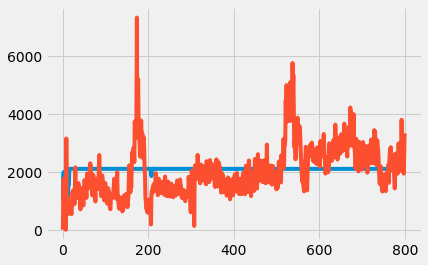

In [111]:
plt.plot(train_results['Train_Predictions'])
plt.plot(train_results['Actuals'])

In [112]:
print('MAE:', metrics.mean_absolute_error(train_results['Actuals'], train_results['Train_Predictions']))
print('MSE:', metrics.mean_squared_error(train_results['Actuals'], train_results['Train_Predictions']))
print('RMSE:', np.sqrt(metrics.mean_squared_error(train_results['Actuals'], train_results['Train_Predictions'])))

MAE: 660.0262018585205
MSE: 706304.2487923709
RMSE: 840.419091163671


In [113]:
# Validation 
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val_Predictions':val_predictions, 'Actuals':y_val})
val_results

4/4 [==============================] - 1s 5ms/step


,Val_Predictions,Actuals
0,2109.979004,2994
1,2109.979004,2802
2,2109.979004,2736
3,2109.979004,2404
4,2109.979004,1838
...,...,...
95,2109.979004,4428
96,2109.979004,6387
97,2109.979004,6567
98,2109.979004,6069


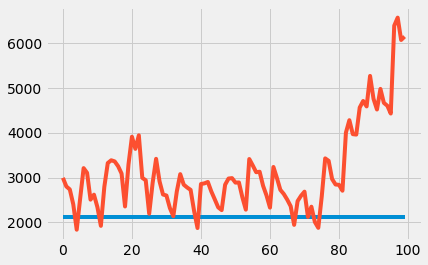

In [114]:
plt.plot(val_results['Val_Predictions'])
plt.plot(val_results['Actuals'])

In [115]:
print('MAE:', metrics.mean_absolute_error(val_results['Actuals'], val_results['Val_Predictions']))
print('MSE:', metrics.mean_squared_error(val_results['Actuals'], val_results['Val_Predictions']))
print('RMSE:', np.sqrt(metrics.mean_squared_error(val_results['Actuals'], val_results['Val_Predictions'])))

MAE: 1062.8984765625
MSE: 2047157.2562025548
RMSE: 1430.789032737725


In [116]:
#Test
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test_Predictions':test_predictions, 'Actuals':y_test})
test_results

5/5 [==============================] - 0s 5ms/step


,Test_Predictions,Actuals
0,2109.979004,2994
1,2109.979004,2802
2,2109.979004,2736
3,2109.979004,2404
4,2109.979004,1838
...,...,...
146,2109.979004,3938
147,2109.979004,3773
148,2109.979004,3721
149,2109.979004,3782


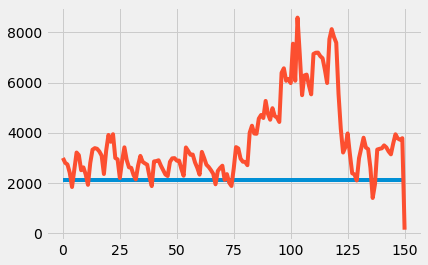

In [117]:
plt.plot(test_results['Test_Predictions'])
plt.plot(test_results['Actuals'])

In [118]:
print('MAE:', metrics.mean_absolute_error(test_results['Actuals'], test_results['Test_Predictions']))
print('MSE:', metrics.mean_squared_error(test_results['Actuals'], test_results['Test_Predictions']))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_results['Actuals'], test_results['Test_Predictions'])))

MAE: 1615.508281379346
MSE: 4999678.760251732
RMSE: 2235.9961449545776
